One vs All Method

Train NMF for each topic separately.

Use all Wiki articles as Background Corpus.

In [1]:
import pandas as pd
import numpy as np
from time import time

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
from math import pi

from omterms.interface import *

import pickle

from ipywidgets import interact, fixed

import requests
import json

import re

## Plots and Prints

In [2]:
categories=['universalism', 'hedonism', 'achievement', 'power',
       'self-direction', 'benevolence', 'conformity', 'tradition', 'stimulation',
       'security']

def plot_radar_chart(doc_topic_cumul, doc):
    # ------- PART 1: Create background
 
    # number of variablecategories
    schwartz =['universalism', 'benevolence', 'conformity', 'tradition',
       'security', 'power', 'achievement', 'hedonism', 'stimulation',
       'self-direction']
    
    schwartz_dist = []
    for sch in schwartz:
        schwartz_dist.append(doc_topic_cumul[doc][categories.index(sch)])
    
    N = len(schwartz)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8,8))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], schwartz)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)


    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values = list(schwartz_dist) + list(schwartz_dist[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)

    # Add legend
    #plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Schwartz Chart - Doc " + str(doc))
    plt.show()
    
    
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
def print_top_words(model, theme, tfidf_vectorizer, n_top_words, n_topics=3):
    feature_names = tfidf_vectorizer.get_feature_names()
    print(color.CYAN + color.BOLD + categories[theme] + color.END)
    for topic_idx, topic in enumerate(model[theme].components_):
        if topic_idx / n_topics == 1:
            break
        message = color.BOLD + "Topic #%d: " % topic_idx + color.END
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def print_cumulative_train_doc_topics(data, doc_topic, doc, n_best):
    test_theme = data.iloc[doc]['theme']
    print(color.BOLD + "Doc " + str(doc) + color.RED +  " (" + test_theme + ")\t: " + color.END, end='')
    dt = doc_topic[doc]
    for i in dt.argsort()[:-n_best - 1:-1]:
        print("(", end='')
        try:
            print(color.CYAN + color.BOLD + categories[i] + color.END, end='')
        except:
            print(color.CYAN + color.BOLD + "General" + color.END, end='')
        print(", %d, %.2lf)  " %(i, dt[i]), end='')    
    print()
    
def print_cumulative_test_doc_topics(doc_topic, doc, n_best):
    print(color.BOLD + "Doc " + str(doc) + "\t: " + color.END, end='')
    dt = doc_topic[doc]
    for i in dt.argsort()[:-n_best - 1:-1]:
        print("(", end='')
        try:
            print(color.CYAN + color.BOLD + categories[i] + color.END, end='')
        except:
            print(color.CYAN + color.BOLD + "General" + color.END, end='')
        print(", %d, %.2lf)  " %(i, dt[i]), end='')    
    print()

def print_doc_topics(doc_topic, doc, n_best):
    print(color.BOLD + "Doc " + str(doc) + "\t: " + color.END, end='')
    for i in doc_topic[doc].argsort()[:-n_best - 1:-1]:
        print("(", end='')
        try:
            print(color.CYAN + color.BOLD + categories[i//3] + color.END, end='')
        except:
            print(color.CYAN + color.BOLD + "General" + color.END, end='')
        print(", %d, %.2lf)  " %(i, doc_topic[doc][i]), end='')    
    print()

def print_train_results(doc_topic, doc, corpus, data):
    print(color.BOLD + "Document " + str(doc) + color.END)
    print()
    print(color.BOLD + "Text: " + color.END)
    print("..." + corpus[doc][len(corpus[doc])//3:len(corpus[doc])//3+500] + "...")
    print()
    print()
    
    print(color.BOLD + "Topic Distribution: " + color.END)
    #print(pd.DataFrame(data=[W_test_norm[doc]], index = [doc], columns=categories+['general']))
    print_cumulative_train_doc_topics(data, doc_topic, doc, 11) 
    print()
    
    plot_radar_chart(doc_topic, doc)
    
def print_test_results(doc_topic, doc, corpus):
    print(color.BOLD + "Document " + str(doc) + color.END)
    print()
    print(color.BOLD + "Text: " + color.END)
    print("..." + corpus[doc][len(corpus[doc])//3:len(corpus[doc])//3+500] + "...")
    print()
    print()
    
    print(color.BOLD + "Topic Distribution: " + color.END)
    
    #print(pd.DataFrame(data=[W_test_norm[doc]], index = [doc], columns=categories+['general']))
    print_cumulative_test_doc_topics(doc_topic, doc, 11)
    print()
    
    plot_radar_chart(doc_topic, doc)

## Helper Functions

In [3]:
def cumulate_W(W, n_topics):
    W_cumul = []
    for d in W:
        temp = []
        for i in range(W.shape[1]//n_topics):
            temp.append(d[i*n_topics:(i+1)*n_topics].sum())
        W_cumul.append(temp)

    W_cumul = np.asarray(W_cumul)
    
    return W_cumul

def normalize_W(W):
    W_cumul_norm = W/(W.sum(axis=1).reshape(W.shape[0], 1))
    W_cumul_norm *= 100
    
    return W_cumul_norm

def export_to_excel(W, docs, doc_names, filepath):
    '''
    Take cumulated W as input.
    Don't forget to put xlsx as file extension '''
    
    df = pd.DataFrame(data=W,index = range(len(W)), columns=categories)
    df['Text'] = docs
    df["name"] = doc_names
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.to_excel(filepath)
    return df

def export_to_csv(W, docs, doc_names, filepath):
    '''
    Take cumulated W as input.
    Don't forget to put csv as file extension '''
    
    df = pd.DataFrame(data=W,index = range(len(W)), columns=categories)
    df['Text'] = docs
    df["name"] = doc_names
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.to_csv(filepath)
    return df

## Main Functions

In [4]:
def preprocess_corpus(corpus):
    
    PPcorpus = [' '.join(list((extract_terms(doc, extra_process = ['stem'])['Stem']+' ')*extract_terms(doc, 
                extra_process = ['stem'])['TF'])) if doc != '' else '' for doc in corpus]
    return PPcorpus
    
def evaluate_docs(docs, nmf, tfidf_test, betaloss = 'kullback-leibler'):
    X_test = tfidf_test
    H_test = nmf.components_
    
    # Fit the NMF model
    t0 = time()

    W_test = nmf.transform(X_test)
    
    return W_test

In [5]:
def print_training_topics(pretrained_filepath):
    nmf_list, tfidf_vectorizer = pickle.load( open( pretrained_filepath, "rb" ) )
    print("\nTopics in NMF model:")
    for i in range(10):
        print_top_words(nmf_list, i, tfidf_vectorizer, n_top_words=5, n_topics=3)

def add_corpus_txt(filepath, test_corpus):
    f = open(filepath, "r")
    txt = f.read()
    test_corpus.append(txt)
    f.close()


def add_corpus_url(url, api_key, test_corpus):
    insightIP = 'http://178.62.229.16'
    insightPort = '8484'
    insightVersion = 'v1.0'

    insightSetting = insightIP + ':' + insightPort + '/api/' + insightVersion 
    request = '/text_analytics/url_scraper?' + 'url=' + url + '&' + 'api_key=' + api_key

    # send a request
    res = requests.get(insightSetting + request)
    test_corpus.append(res.json()['text'])
    
def evaluate_test_corpus(pretrained_filepath, test_corpus):
    nmf_list, tfidf_vectorizer = pickle.load( open( pretrained_filepath, "rb" ) )
    test_corpusPP = preprocess_corpus(test_corpus)
    print()
    print('-'*30)
    print()
    print("Extracting tf-idf features for NMF...")
    t0 = time()
    tfidf_test = tfidf_vectorizer.transform(test_corpusPP)
    #tfidf = tfidf_vectorizer.transform(corpusX)
    print(tfidf_test.shape[1])
    n_features = tfidf_test.shape[1]
    print("done in %0.2fs." % (time() - t0))

    W_test_list = []
    for i, nmf in enumerate(nmf_list):
        print("Fitting NMF for " + str(categories[i]))
        W_test = evaluate_docs(test_corpusPP, nmf, tfidf_test, betaloss = 'kullback-leibler')
        W_test_list.append(W_test)
        
    # Sum up sub topics
    W_test_norm_list = []
    for W in W_test_list:
        W_test_cumul = cumulate_W(W, n_topics=3)
        W_test_norm = normalize_W(W_test_cumul)
        W_test_norm_list.append(W_test_norm)
    W_test_norm = np.asarray(W_test_norm_list).T[0]
    W_test_norm = np.nan_to_num(W_test_norm)
    
    return W_test_norm

def print_interactive_test_results(W_test_norm, test_corpus):
    interact(print_test_results, doc_topic=fixed(W_test_norm), doc = (0, len(W_test_norm)-1, 1), corpus=fixed(test_corpus))

## Print Pretrained Model's Topics

**nmf2_pretrained.p** or **nmf2_pretrained_pruned.p** includes pretrained NMF model generated using **Semi-Supervised-NMF-train-v2.ipynb** notebook. It has the nmf model and tfidf_vectorizer.

for the details of purned version see also **"OMTermz HZ.ipynb"**

In [6]:
pre_trained_doc = "nmf2_pretrained_pruned.p"
print_training_topics(pre_trained_doc)


Topics in NMF model:
universalism
Topic #0: group topic analyt individu first
Topic #1: human state larg unit becam
Topic #2: disarma term intern govern known

hedonism
Topic #0: reaction shock psycholog problem interest
Topic #1: sometim us presenc shut unfamiliar
Topic #2: see repres studi time import

achievement
Topic #0: motiv theori relat role lower
Topic #1: loan social merchant tribe refer
Topic #2: other owen scale peopl primari

power
Topic #0: compos use partner toxic belong
Topic #1: articl may tool bia law
Topic #2: lower leadership specialti environ peopl

self-direction
Topic #0: gener made resourc benedek romantic
Topic #1: liberti known character ratifi use
Topic #2: use well domin olivero variou

benevolence
Topic #0: seem natur theori need mythomania
Topic #1: sometim upon portal school exampl
Topic #2: thought discrimin repeat definit one

conformity
Topic #0: show great voltag note thu
Topic #1: other time problem still day
Topic #2: uncodifi collectivist rewritte

## Evaluating Different Documents

Adding two example documents to the test_corpus.

In [7]:
#Pope ted talk, https://www.ted.com/speakers/pope_francis
# US Department of Defense, https://www.defense.gov/About/
doc_names = ["pope.txt", "dod.txt", "https://www.nationalgeographic.com/science/space/solar-system/earth/"]

In [8]:
def add_corpus_docs(doc_names, test_corpus, insigth_api_key):
    for doc in doc_names:
        if re.match("^(http|https)://", doc) is None:
            add_corpus_txt(doc, test_corpus)
        else:
            add_corpus_url(doc, insigth_api_key, test_corpus)

Crawling a website using InSight API and adding its text to test_corpus.

Always check the text, added to the corpus via add_corpus_url. Because websites can have unexpected embedded texts.

In [9]:
test_corpus = []
insigth_api_key = "" #needs to be filled
add_corpus_docs(doc_names, test_corpus, insigth_api_key)

Evaluate model for the test_corpus.

In [10]:
W_test_norm = evaluate_test_corpus(pre_trained_doc, test_corpus)

Outputs will be written under /Users/brain/Desktop/company/algosis/semi-supervised-nmf/
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 1857
Cleaning process: Initial size of tokens = 1857
Reduction due to punctuations and stopwords = 1332.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 1332
Percentage = 72%
Stemming the terms in the corpus ..
Done.
COMPLETED.
Outputs will be written under /Users/brain/Desktop/company/algosis/semi-supervised-nmf/
Configuring the text cle

Results for test_corpus

Document 1

Text: 
...as one of the most efficient office buildings in the world. Despite 17.5 miles of corridors it takes only seven minutes to walk between any two points in the building.

The national security depends on our defense installations and facilities being in the right place, at the right time, with the right qualities and capacities to protect our national resources. Those resources have never been more important as America fights terrorists who plan and carry out attacks on our facilities and our peop...


Topic Distribution: 
Doc 1	: (universalism, 0, 93.31)  (security, 9, 80.21)  (power, 3, 57.19)  (self-direction, 4, 44.34)  (tradition, 7, 27.82)  (achievement, 2, 21.42)  (conformity, 6, 9.57)  (hedonism, 1, 6.58)  (stimulation, 8, 1.33)  (benevolence, 5, 0.18)  



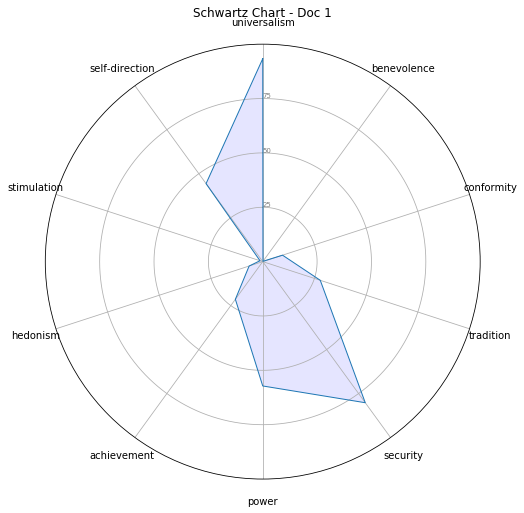

In [11]:
print_interactive_test_results(W_test_norm, test_corpus)

In [12]:
df = export_to_excel(W_test_norm, test_corpus, doc_names, filepath = 'output.xlsx')
df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/io/excel.py:784: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  self.book.remove_sheet(self.book.worksheets[0])


,name,universalism,hedonism,achievement,power,self-direction,benevolence,conformity,tradition,stimulation,security,Text
0,pope.txt,17.221134,51.479285,38.358007,40.985174,22.495198,58.339819,77.840740,44.710876,33.945197,24.239796,"Good evening – or, good morning, I am not sure..."
1,dod.txt,93.310198,6.583666,21.415460,57.187346,44.343160,0.179274,9.573765,27.817381,1.326130,80.208205,\nOn behalf of the Secretary of Defense and De...
2,https://www.nationalgeographic.com/science/spa...,86.540833,30.710354,8.226187,48.418611,32.039996,19.211673,23.049986,2.614833,92.023435,48.482845,"Earth, our home planet, is the only planet in ..."


In [13]:
df = export_to_csv(W_test_norm, test_corpus, doc_names, filepath = 'output.csv')
df.head()

,name,universalism,hedonism,achievement,power,self-direction,benevolence,conformity,tradition,stimulation,security,Text
0,pope.txt,17.221134,51.479285,38.358007,40.985174,22.495198,58.339819,77.840740,44.710876,33.945197,24.239796,"Good evening – or, good morning, I am not sure..."
1,dod.txt,93.310198,6.583666,21.415460,57.187346,44.343160,0.179274,9.573765,27.817381,1.326130,80.208205,\nOn behalf of the Secretary of Defense and De...
2,https://www.nationalgeographic.com/science/spa...,86.540833,30.710354,8.226187,48.418611,32.039996,19.211673,23.049986,2.614833,92.023435,48.482845,"Earth, our home planet, is the only planet in ..."
